## Análisis - "Las cinco grandes ligas" temporada 2015/2016 (masculina)

Tras hacer un análisis de cada una de las cinco grandes ligas durante la temporada 2015/2016, en este notebook en cuestión, vamos a analizar las cinco grandes ligas conjuntamente, es decir, suponiendo que las 5 grandes ligas son una única liga por así decirlo. Este análisis nos va a ayudar a entender que características son más importantes a la hora de tomar la decisión por parte del modelo de ML para decidir si el equipo va a ganar, perder o empatar el partido.

Cargamos los datos de los partidos para entrenar el modelo y poder hacer el estudio de explicabilidad.

In [1]:
import os
import pandas as pd

output_dir = "data/reduced/"
filename = "Top_5_leagues.csv"
output_path = os.path.join(output_dir, filename)

if os.path.exists(output_path):
    print(f"Matches from the competition loaded from {output_path}")
    matches_in_Top5Leagues = pd.read_csv(output_path)
else:
    print("You don't have data from the competition yet. Please run the notebook '0_datasets_building.ipynb' first.")

Matches from the competition loaded from data/reduced/Top_5_leagues.csv


In [2]:
matches_in_Top5Leagues.head(5)

,match_id,shots_on_target_ratio_home,shots_on_target_ratio_away,average_shots_on_target_distance_home,average_shots_on_target_distance_away,shots_inside_area_ratio_home,shots_inside_area_ratio_away,pass_success_ratio_home,pass_success_ratio_away,cross_success_ratio_home,...,percentage_shots_under_pressure_home,percentage_shots_inside_area_under_pressure_home,percentage_passes_under_pressure_home,percentage_passes_inside_area_under_pressure_home,percentage_set_piece_shots_home,percentage_set_piece_shots_inside_area_home,percentage_substitutions_home,percentage_tactical_substitutions_home,percentage_tactical_changes_home,percentage_formation_changes_home
0,3890267,0.375000,0.461538,16.622853,13.820947,0.750000,0.692308,0.832013,0.755051,0.250000,...,0.250000,0.400000,0.574713,0.50,0.266667,0.300000,0.5,0.5,0.500000,0.000000
1,3890265,0.150000,0.272727,20.255117,17.607160,0.500000,0.545455,0.772727,0.828261,0.318182,...,0.769231,0.750000,0.441718,0.75,0.680000,0.727273,0.5,0.5,0.500000,0.666667
2,3890264,0.133333,0.312500,26.271612,17.542449,0.333333,0.500000,0.767241,0.704301,0.200000,...,0.500000,0.400000,0.595376,1.00,0.476190,0.500000,0.5,0.6,0.333333,0.500000
3,3890263,0.272727,0.357143,18.619963,21.381858,0.454545,0.428571,0.688000,0.620690,0.214286,...,0.444444,0.571429,0.502924,0.50,0.458333,0.454545,0.5,0.5,1.000000,1.000000
4,3890262,0.272727,0.357143,20.860604,15.628223,0.818182,0.428571,0.490909,0.657431,0.300000,...,0.222222,0.250000,0.375000,0.60,0.400000,0.600000,0.5,0.5,0.200000,0.000000


Una vez ya tenemos los datos cargados, entrenamos el mejor modelo (seleccionado tras la experimentación) y mostramos sus resultados. El mejor modelo es un Logistic Regression que utiliza una técnica PCA para el preprocesamiento de los datos (obteniendo un 64.38% de precisión en los datos de prueba); el caso es que es complicado de hacer un estudio de explicabilidad de este tipo de modelos, por lo que vamos a utilizar uno que tiene un poco menos de precisión (63.56% en los datos de prueba) pero que el estudio de explicabilidad es más entendible y en este caso es un modelo Random Forest que utiliza una técnica de oversampling en el preprocesamiento sobre los datos de entrenamiento.

In [3]:
from src.analysis import top5Leagues_best_model

best_model_Top5Leagues, evaluation_metrics, X_train_Top5Leagues, X_test_Top5Leagues, encoder_Top5Leagues, match_ids_test = top5Leagues_best_model(matches_in_Top5Leagues)
print(f"The best model for 'The top 5 leagues' is {best_model_Top5Leagues}")
print(f"The evaluation metrics for the best model are:")
evaluation_metrics.head()

The best model for 'The top 5 leagues' is RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=56,
                       random_state=42)
The evaluation metrics for the best model are:


,Train Accuracy,Test Accuracy,Precision Macro,Precision Weighted,Recall Macro,Recall Weighted,F1 Macro,F1 Weighted
Random Forest Oversampling,0.859053,0.635616,0.598653,0.626413,0.60653,0.635616,0.599698,0.628597


Una vez ya tenemos el mejor modelo entrenado comenzamos el análisis de explicabilidad.

### Estudio global

Vamos a comenzar por un estudio global. 

En este caso, al ser el mejor modelo Random Forest, nos basaremos en la importancia de las características proporcionada por el modelo a través del método `feature_importances_`.
- A diferencia de la regresión logística, que asigna coeficientes específicos a cada clase, Random Forest evalúa la relevancia de cada variable para el modelo en su conjunto, sin distinguir entre clases.
- Este modelo captura tanto relaciones lineales como no lineales, permitiendo analizar interacciones entre múltiples factores y su impacto en la predicción del resultado.
- Sin embargo, no indica la dirección del efecto de cada característica (positiva o negativa), sino únicamente su importancia relativa en el rendimiento del modelo.

El gráfico presentado a continuación muestra la importancia global de cada característica en la predicción de los resultados de los partidos en "Las cinco grandes ligas".
- Valores más altos indican que una característica tiene mayor peso en las predicciones del modelo.
- Valores cercanos a cero indican que la característica no aporta información significativa para la clasificación del resultado.

Este análisis nos permite identificar qué factores son clave en la predicción del resultado de los partidos, considerando relaciones más complejas y capturando patrones que un modelo lineal no podría detectar.

Features with zero importance across all classes:
['is_valid_last_3_matches_form_away', 'is_valid_win_last_home_match_home_team', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'percentage_players_off_home']


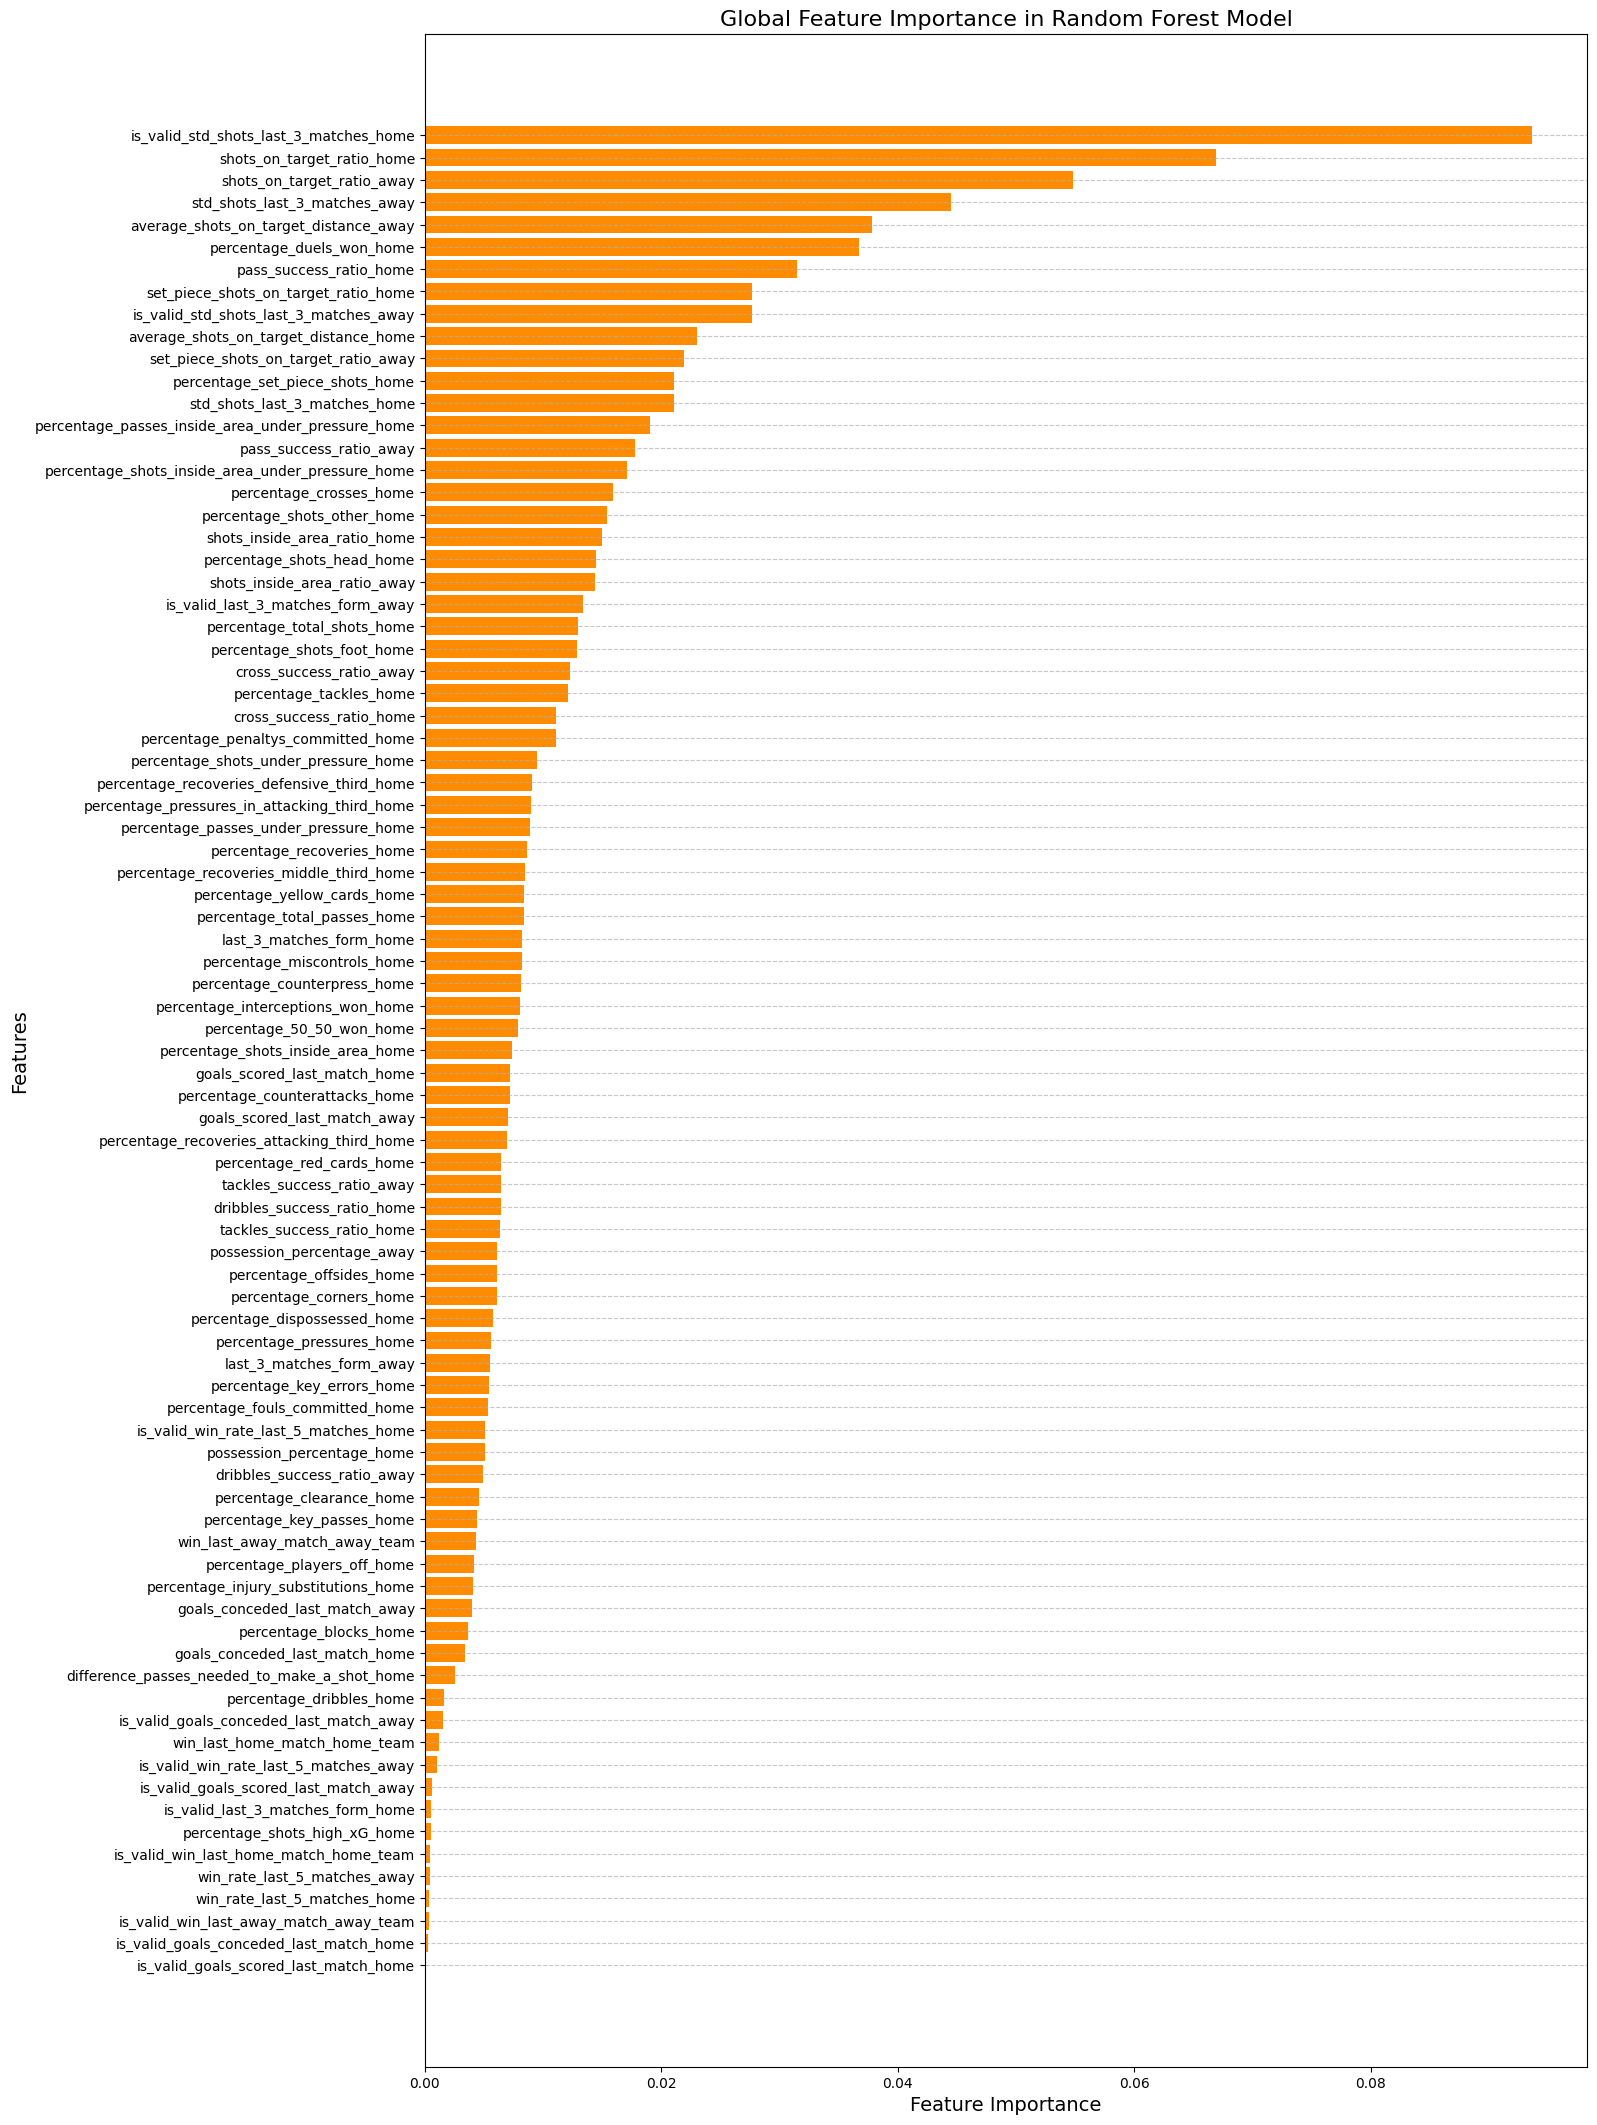

In [4]:
from src.analysis import random_forest_global_analysis

random_forest_global_analysis(best_model_Top5Leagues)

El modelo Random Forest ha determinado la relevancia de cada característica en la predicción del resultado de los partidos en "Las cinco grandes ligas". A diferencia de la Regresión Logística, aquí se mide la importancia relativa de cada variable para el modelo en su conjunto, sin distinguir entre clases específicas (victoria local, empate o victoria visitante). Vamos a analizar el gráfico:

- **Caracterísiticas más importantes en la predicción**: Las características con mayor importancia en el modelo son aquellas que han tenido un impacto significativo en la clasificación del resultado del partido. Aunque no podemos determinar si una variable favorece a un equipo u otro, sí podemos intuir que estas características han sido relevantes en la toma de decisiones del modelo.
    - `is_valid_std_shots_last_3_matches_home`: Es la característica más influyente. Esta métrica indica si es válida o no la desviación estándar de los tiros en los últimos 3 partidos del equipo local. Esto sugiere que la variabilidad en la producción ofensiva reciente del equipo local puede estar muy correlacionada con el resultado final del partido.
    - `shots_on_target_ratio_home` y `shots_on_target_ratio_away`: La precisión en los tiros a puerta, tanto del equipo local como del visitante, se sitúan como factores clave. Estos indicadores sugieren que la eficiencia ofensiva de ambos equipos es fundamental en el desenlace de los partidos.
    - `std_shots_last_3_matches_away`, `std_shots_last_3_matches_home`, `average_shots_on_target_distance_away` y `average_shots_on_target_distance_home`: La desviación estándar en el número de disparos del local y visitante y la distancia media de los tiros del equipo local y visitante aportan información adicional. Mientras que la desviación indica consistencia o irregularidad ofensiva, la distancia sugiere si los equipos buscan tiros más cercanos o arriesgan desde lejos.
    - `percentage_duels_won_home`: La cantidad de duelos ganados por el equipo local muestra que el dominio físico y competitivo en el campo puede tener un rol en los resultados. Esta métrica refleja la intensidad con la que el equipo local compite.
    - `pass_success_ratio_home` y `pass_success_ratio_away`: La calidad en la circulación del balón, medida por el porcentaje de pases acertados, es otro componente importante. Un juego fluido y preciso, por parte de ambos equipos, se asocia con mejores resultados.
    - `set_piece_shots_on_target_ratio_home`, `set_piece_shots_on_target_ratio_away` y `percentage_set_piece_shots_home`: La capacidad de transformar jugadas a balón parado en tiros peligrosos se revela como una habilidad que el modelo considera valiosa. También el porcentaje de tiros desde jugadas a balón parado de los equipo en el partido. Los equipos que aprovechan sus oportunidades desde córners o faltas tienden a ser más competitivos.
    - `percentage_shots_inside_area_under_pressure_home`, `percentage_passes_inside_area_under_pressure_home`, `percentage_shots_under_pressure_home` y `percentage_passes_under_pressure_home`: El porcentaje de tiros y pases (desde dentro del área) bajo presión de los dos equipos en el partido son una métrica importante ya que muestra como un equipo complica al otro cuando esta en su área y como es además capaz de responder el equipo ante la presión.
    - `shots_inside_area_ratio_home` y `shots_inside_area_ratio_away`: La cantidad de tiros realizados dentro del área también aparece como un buen indicador ofensivo. Estos disparos suelen tener más probabilidad de acabar en gol, lo que puede explicar su relevancia para el modelo.
    - `percentage_crosses_home`, `cross_success_ratio_home`, `cross_success_ratio_away`, `percentage_shots_other_home`, `percentage_shots_head_home` y `percentage_shots_foot_home`: Aspectos que reflejan el estilo ofensivo del equipo local, como su uso de centros o el tipo de disparos utilizados, también han sido tenidos en cuenta.
    - `percentage_total_shots_home`, `percentage_tackles_home` y `percentage_total_passes_home`: El volumen total de disparos, pases y el número de entradas defensivas refuerzan la idea de que tanto la capacidad ofensiva como la presión defensiva del equipo local son variables interpretadas como útiles por el modelo.
    - `percentage_key_errors_home` y `percentage_penaltys_committed_home`: El porcentaje de errores claves y penaltis cometidos en el partido por parte de ambos equipos también juega un papel importante.
    - `percentage_interceptions_won_home`, `percentage_pressures_in_attacking_third_home`, `percentage_recoveries_in_middle_third_home` y `percentage_recoveries_in_defensive_third_home`: También hay varias métricas defensivas que toman importancia a la hora de definir quien gana el partido.
    - `goals_scored_last_match_home` y `goals_scored_last_match_away`: El número de goles anotados en el partido justo posterior por ambos equipos cobrá importancia a la hora de decidir el ganador del partido.

- **Características sin importancia en la predicción**: El modelo ha determinado que varias características no aportan información relevante en la clasificación del resultado del partido. Esto no significa que estas variables no tengan influencia en el fútbol de "Las cinco grandes ligas", sino que, dentro de los datos analizados, el modelo no ha encontrado una relación clara con los resultados.
    - **Variable relacionadas con la validez/disponibilidad de datos recientes**: `is_valid_last_3_matches_form_away`, `is_valid_win_last_home_match_home_team`, `is_valid_goals_scored_last_match_home`, `is_valid_goals_scored_last_match_away`. Es posible que no aporten valor predictivo si ya se están utilizando otras métricas más directas.
    - **Variables que rara vez toman valores diferentes**: `percentage_players_off_home`, `percentage_injuries_substitutions`. Este tipo de métrica, más rara e infrecuente, probablemente no ha presentado patrones consistentes en los datos.
    - ****:  
    - **Métricas temporales que no toman importancia**: `goals_conceded_last_match_home`, `goals_conceded_last_match_away`, `win_last_home_match_home_team`, `win_last_away_match_away_team`, `win_rate_last_5_matches_home` y `win_rate_last_5_matches_away`. Estas métricas temporales no toman importancia.
    - **Métricas ofensivas y de juego que toman menos importancia de la esperada**: Métricas como `percentage_shots_high_xG_home` y `difference_passes_needed_to_make_a_shot` toman menos importancia de lo que podríamos esperar en un principio ya que parecía que podrían influir claramente en el juego.

**Conclusiones generales**: 

El modelo de Random Forest ha revelado que, en el conjunto de Las cinco grandes ligas, las métricas más relevantes para predecir el resultado de los partidos están relacionadas principalmente con la eficiencia ofensiva, la consistencia en el número de tiros y la precisión en jugadas clave. Variables como la desviación estándar de los tiros en partidos recientes, la proporción de tiros a puerta, la distancia media de los disparos y el éxito en jugadas a balón parado han sido fundamentales en la clasificación del modelo.

Por el contrario, el modelo ha otorgado poca o nula importancia a factores defensivos como las recuperaciones, las presiones o los bloqueos, así como a métricas de rendimiento reciente como victorias anteriores o goles marcados en el último partido. Esto indica que, en los datos analizados, estos aspectos no han mostrado una relación consistente con el resultado final.

Es importante destacar que el modelo no ofrece información sobre la dirección del impacto de cada variable, es decir, no indica si un mayor valor en una característica favorece a un equipo u otro. Solo señala que dichas características han sido más utilizadas en las decisiones del modelo, lo que refleja su peso relativo en la predicción.

Desde un punto de vista táctico, podemos intuir que los equipos que muestran regularidad ofensiva, eficiencia en los tiros y un uso efectivo de las jugadas a balón parado tienden a estar más presentes en los patrones de éxito detectados por el modelo. Además, la atención a situaciones bajo presión sugiere que el contexto de los tiros o pases también es importante, más allá del simple volumen de acciones.

En conclusión, en el análisis conjunto de las grandes ligas europeas, el rendimiento ofensivo, la precisión y ciertos elementos del estilo de juego se perfilan como los factores más influyentes en los resultados, aportando claves útiles para la comprensión del fútbol de alto nivel en estas competiciones.